# Lab | Making predictions with logistic regression
In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

### Instructions
1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

In [174]:
# prep: import modules and get pwd in
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
# password = getpass.getpass()

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [127]:
# Getting the data out of SQL

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''SELECT *
FROM sakila.film
JOIN sakila.inventory i
USING (film_id)
JOIN sakila.rental r
USING (inventory_id)
WHERE (r.rental_date >= '2005-01-01') AND (r.rental_date <= '2005-12-31');'''

# Retrieving the query using the engine and creating our python dataframe
data = pd.read_sql_query(query, engine)
data.head()

,inventory_id,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,...,special_features,last_update,store_id,last_update,rental_id,rental_date,customer_id,return_date,staff_id,last_update
0,367,80,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,2006,1,None,7,2.99,148,...,Trailers,2006-02-15 05:03:42,1,2006-02-15 05:09:17,1,2005-05-24 22:53:30,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,1525,333,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,7,2.99,126,...,"Trailers,Behind the Scenes",2006-02-15 05:03:42,2,2006-02-15 05:09:17,2,2005-05-24 22:54:33,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,1711,373,GRADUATE LORD,A Lacklusture Epistle of a Girl And a A Shark ...,2006,1,None,7,2.99,156,...,"Trailers,Behind the Scenes",2006-02-15 05:03:42,2,2006-02-15 05:09:17,3,2005-05-24 23:03:39,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,2452,535,LOVE SUICIDES,A Brilliant Panorama of a Hunter And a Explore...,2006,1,None,6,0.99,181,...,"Trailers,Behind the Scenes",2006-02-15 05:03:42,1,2006-02-15 05:09:17,4,2005-05-24 23:04:41,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,2079,450,IDOLS SNATCHERS,A Insightful Drama of a Car And a Composer who...,2006,1,None,5,2.99,84,...,Trailers,2006-02-15 05:03:42,2,2006-02-15 05:09:17,5,2005-05-24 23:05:21,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53


2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [128]:
# Query creation to filter films rented Aug2005
query1 = '''SELECT *
FROM sakila.rental r
WHERE (r.rental_date >= '2005-08-01') AND (r.rental_date <= '2005-08-31');'''

data1 = pd.read_sql_query(query1, engine)
data1.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,10181,2005-08-01 00:00:44,3111,113,2005-08-04 19:33:44,1,2006-02-15 21:30:53
1,10182,2005-08-01 00:08:01,4112,578,2005-08-09 18:14:01,2,2006-02-15 21:30:53
2,10183,2005-08-01 00:08:01,4319,377,2005-08-09 20:41:01,1,2006-02-15 21:30:53
3,10184,2005-08-01 00:09:33,2785,77,2005-08-05 04:12:33,2,2006-02-15 21:30:53
4,10185,2005-08-01 00:12:11,1266,64,2005-08-03 03:03:11,1,2006-02-15 21:30:53


In [129]:
# Converting rental_date column into a string

data['rental_date'] = data['rental_date'].astype('string')

In [130]:
data['rental_date'].value_counts()

2005-08-18 07:55:09    2
2005-07-10 20:41:41    2
2005-07-27 22:38:53    2
2005-08-23 08:48:43    2
2005-08-19 16:47:41    2
                      ..
2005-08-18 00:04:12    1
2005-05-30 10:43:38    1
2005-07-27 01:00:34    1
2005-08-20 21:31:52    1
2005-07-10 06:02:25    1
Name: rental_date, Length: 15814, dtype: Int64

In [131]:
# Defining a function to assign 1 to films rented Aug05 and 0 to the others.

def rentedaug(rental_month):
    if (rental_month >= '2005-08-01') and (rental_month <= '2005-08-31'):
        return 1
    else:
        return 0

In [132]:
# Applying the function to the 'rental_date' column from our dataset and creating a new column with the 0-1 values.

data['rental_aug'] = list(map(rentedaug, data['rental_date']))

In [133]:
data

,inventory_id,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,...,last_update,store_id,last_update,rental_id,rental_date,customer_id,return_date,staff_id,last_update,rental_aug
0,367,80,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,2006,1,None,7,2.99,148,...,2006-02-15 05:03:42,1,2006-02-15 05:09:17,1,2005-05-24 22:53:30,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53,0
1,1525,333,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,7,2.99,126,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,2,2005-05-24 22:54:33,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53,0
2,1711,373,GRADUATE LORD,A Lacklusture Epistle of a Girl And a A Shark ...,2006,1,None,7,2.99,156,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,3,2005-05-24 23:03:39,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53,0
3,2452,535,LOVE SUICIDES,A Brilliant Panorama of a Hunter And a Explore...,2006,1,None,6,0.99,181,...,2006-02-15 05:03:42,1,2006-02-15 05:09:17,4,2005-05-24 23:04:41,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53,0
4,2079,450,IDOLS SNATCHERS,A Insightful Drama of a Car And a Composer who...,2006,1,None,5,2.99,84,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,5,2005-05-24 23:05:21,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15857,772,168,COMANCHEROS ENEMY,A Boring Saga of a Lumberjack And a Monkey who...,2006,1,None,5,0.99,67,...,2006-02-15 05:03:42,1,2006-02-15 05:09:17,16045,2005-08-23 22:25:26,14,2005-08-25 23:54:26,1,2006-02-15 21:30:53,1
15858,4364,951,VOYAGE LEGALLY,A Epic Tale of a Squirrel And a Hunter who mus...,2006,1,None,6,0.99,78,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,16046,2005-08-23 22:26:47,74,2005-08-27 18:02:47,2,2006-02-15 21:30:53,1
15859,2088,452,ILLUSION AMELIE,A Emotional Epistle of a Boat And a Mad Scient...,2006,1,None,4,0.99,122,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,16047,2005-08-23 22:42:48,114,2005-08-25 02:48:48,2,2006-02-15 21:30:53,1
15860,2019,439,HUNCHBACK IMPOSSIBLE,A Touching Yarn of a Frisbee And a Dentist who...,2006,1,None,4,4.99,151,...,2006-02-15 05:03:42,1,2006-02-15 05:09:17,16048,2005-08-23 22:43:07,103,2005-08-31 21:33:07,1,2006-02-15 21:30:53,1


In [134]:
data['rental_aug'].value_counts()

0    10176
1     5686
Name: rental_aug, dtype: int64

3. Read the data into a Pandas dataframe.

In [135]:
# Checking shape and data types
print(data.shape)
data.dtypes

(15862, 23)


inventory_id                     int64
film_id                          int64
title                           object
description                     object
release_year                     int64
language_id                      int64
original_language_id            object
rental_duration                  int64
rental_rate                    float64
length                           int64
replacement_cost               float64
rating                          object
special_features                object
last_update             datetime64[ns]
store_id                         int64
last_update             datetime64[ns]
rental_id                        int64
rental_date                     string
customer_id                      int64
return_date             datetime64[ns]
staff_id                         int64
last_update             datetime64[ns]
rental_aug                       int64
dtype: object

4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [136]:
data.head(2)

,inventory_id,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,...,last_update,store_id,last_update,rental_id,rental_date,customer_id,return_date,staff_id,last_update,rental_aug
0,367,80,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,2006,1,None,7,2.99,148,...,2006-02-15 05:03:42,1,2006-02-15 05:09:17,1,2005-05-24 22:53:30,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53,0
1,1525,333,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,7,2.99,126,...,2006-02-15 05:03:42,2,2006-02-15 05:09:17,2,2005-05-24 22:54:33,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53,0


In [137]:
data.columns

Index(['inventory_id', 'film_id', 'title', 'description', 'release_year',
       'language_id', 'original_language_id', 'rental_duration', 'rental_rate',
       'length', 'replacement_cost', 'rating', 'special_features',
       'last_update', 'store_id', 'last_update', 'rental_id', 'rental_date',
       'customer_id', 'return_date', 'staff_id', 'last_update', 'rental_aug'],
      dtype='object')

In [138]:
# Dropping redundant features
data = data.drop(['release_year',
       'language_id', 'original_language_id','special_features',
       'last_update', 'store_id', 'last_update', 'rental_id','customer_id','staff_id', 'last_update'],axis=1)
data.head(2)

,inventory_id,film_id,title,description,rental_duration,rental_rate,length,replacement_cost,rating,rental_date,return_date,rental_aug
0,367,80,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,7,2.99,148,21.99,G,2005-05-24 22:53:30,2005-05-26 22:04:30,0
1,1525,333,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,7,2.99,126,16.99,R,2005-05-24 22:54:33,2005-05-28 19:40:33,0


In [139]:
# Dropping more redundant features
# data = data.drop(['inventory_id', 'film_id','description'],axis=1)
data.head(2)

,inventory_id,film_id,title,description,rental_duration,rental_rate,length,replacement_cost,rating,rental_date,return_date,rental_aug
0,367,80,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,7,2.99,148,21.99,G,2005-05-24 22:53:30,2005-05-26 22:04:30,0
1,1525,333,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,7,2.99,126,16.99,R,2005-05-24 22:54:33,2005-05-28 19:40:33,0


In [140]:
# Categorical columns analisis and transformation
cat = data.select_dtypes(include = np.object)
cat['rating'].value_counts()

PG-13    3543
NC-17    3249
PG       3178
R        3152
G        2740
Name: rating, dtype: int64

In [141]:
# Cleaning the 'Rating' column

def cleanRating(x):
    if 'PG-13' in x:
        return "PG"
    elif 'PG' in x:
        return "PG"
    elif 'NC' in x:
        return "NC"
    elif 'R' in x:
        return "R"
    else:
        return "G"

In [142]:
cat['rating'] = cat['rating'].apply(cleanRating)
cat['rating'].value_counts()

<ipython-input-142-298729cb7471>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['rating'] = cat['rating'].apply(cleanRating)


PG    6721
NC    3249
R     3152
G     2740
Name: rating, dtype: int64

In [143]:
# Dropping the target variable
categorical = pd.get_dummies(cat, columns=['rating'])

In [144]:
categorical.head()

,title,description,rating_G,rating_NC,rating_PG,rating_R
0,BLANKET BEVERLY,A Emotional Documentary of a Student And a Gir...,1,0,0,0
1,FREAKY POCUS,A Fast-Paced Documentary of a Pastry Chef And ...,0,0,0,1
2,GRADUATE LORD,A Lacklusture Epistle of a Girl And a A Shark ...,1,0,0,0
3,LOVE SUICIDES,A Brilliant Panorama of a Hunter And a Explore...,0,0,0,1
4,IDOLS SNATCHERS,A Insightful Drama of a Car And a Composer who...,0,1,0,0


In [158]:
categorical = categorical.drop(['description'],axis=1)

In [145]:
categorical = categorical.drop(['title'], axis=1)

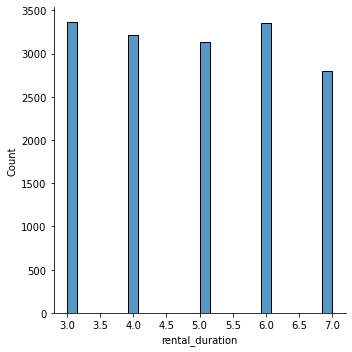

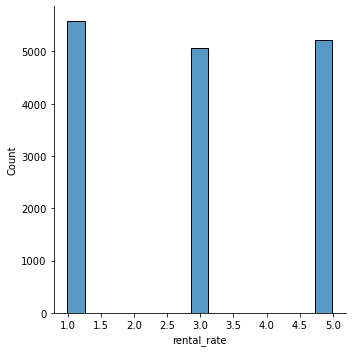

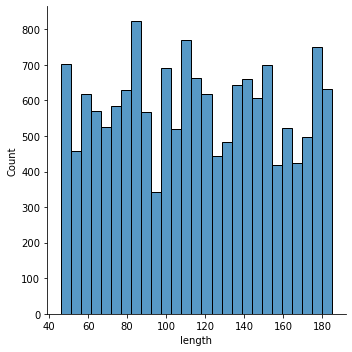

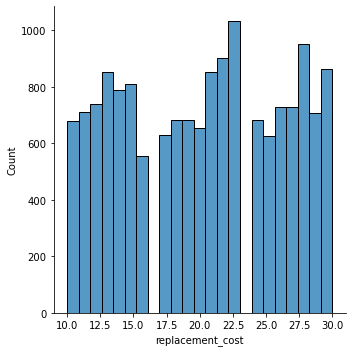

In [146]:
# Numerical columns: looking at the scale and distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data['rental_duration'])
plt.show()

sns.displot(data['rental_rate'])
plt.show()

sns.displot(data['length'])
plt.show()

sns.displot(data['replacement_cost'])
plt.show()

In [147]:
# Normalization of our numerical features

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Creating new df with numerical columns
X = data.select_dtypes(include = np.number)

# Scaling the Data with MinMaxScaler
transformer = MinMaxScaler().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized, columns = X.columns) # naming columns as before
x = x.drop(['rental_aug'], axis=1)
x

,inventory_id,film_id,rental_duration,rental_rate,length,replacement_cost
0,0.079913,0.079079,1.00,0.5,0.733813,0.60
1,0.332751,0.332332,1.00,0.5,0.575540,0.35
2,0.373362,0.372372,1.00,0.5,0.791367,0.25
3,0.535153,0.534535,0.75,0.0,0.971223,0.60
4,0.453712,0.449449,0.50,0.5,0.273381,1.00
...,...,...,...,...,...,...
15857,0.168341,0.167167,0.50,0.0,0.151079,0.70
15858,0.952620,0.950951,0.75,0.0,0.230216,0.95
15859,0.455677,0.451451,0.25,0.0,0.546763,0.30
15860,0.440611,0.438438,0.25,1.0,0.755396,0.95


In [148]:
# checking correlation between numerical
corr_matrix = x.corr(method='pearson')
corr_matrix

,inventory_id,film_id,rental_duration,rental_rate,length,replacement_cost
inventory_id,1.000000,0.999959,-0.054851,0.006821,0.054973,-0.039777
film_id,0.999959,1.000000,-0.054448,0.006843,0.055034,-0.039176
rental_duration,-0.054851,-0.054448,1.000000,0.034686,0.055037,-0.027167
rental_rate,0.006821,0.006843,0.034686,1.000000,0.055275,-0.064794
length,0.054973,0.055034,0.055037,0.055275,1.000000,0.026970
replacement_cost,-0.039777,-0.039176,-0.027167,-0.064794,0.026970,1.000000


5. Create a logistic regression model to predict this variable from the cleaned data.

In [159]:
# x-y build and categorical-numerical df concatenation
y = data['rental_aug']
X = np.concatenate((x, categorical), axis=1)

In [161]:
# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=97)

In [162]:
# Logistic Regression model building
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [163]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.6369137670196672

## 6. Evaluate the results.

#### MSE. & RMSE


In [172]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,predicted)
print(mse)

0.3630862329803328


In [173]:
from sklearn import linear_model
import math

rmse = math.sqrt(mse)
print(rmse)

0.602566372261457


#### MAE

In [171]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test,predicted)
print('MAE: %.3f' % mae)

MAE: 0.363
